In [98]:
from pathlib import Path
import pandas as pd
import numpy as np
from joblib import load, dump
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import LabelEncoder
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import warnings
warnings.filterwarnings("ignore")

In [99]:
BASE_DIR = Path.cwd().parent
pio.templates.default = 'plotly_white'

In [71]:
df_hosts_reviews_en_labeled = pd.read_parquet(BASE_DIR / 'processed_data' / 'hosts_reviews_en_topics.parquet')

In [72]:
df_hosts_reviews_en_labeled['neighbourhood'] = df_hosts_reviews_en_labeled['neighbourhood'].str.lower()
df = df_hosts_reviews_en_labeled[['comments', 'neighbourhood']]
remove_neighb = 'enskede|årsta|vantörs|arsta|vantors|östermalm|ostermalm|\
                    kungsholm|skarpnäck|skarpnack|södermalm|sodermalm|skärholmen|\
                    skarholmen|bromma|hägersten|hagersten|liljeholmen|farsta|älvsjö|alvsjo|\
                    vällingby|vallingby|rinkeby|tensta|spånga|spanga|hässelby|hasselby|norrmalm|'
df.loc[:, 'comments'] = df['comments'].str.replace(remove_neighb, '', regex=True)

In [73]:
df_extended = df_hosts_reviews_en_labeled[['comments', 'neighbourhood', 
                                           'price', 'number_of_reviews', 'reviews_per_month',
                                          'number_of_reviews_ltm', 'room_type']]
df_extended = pd.get_dummies(df_extended, columns=['room_type'], drop_first=True)
cols = ['room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room']
df_extended[cols] = df_extended[cols].astype(int)

In [74]:
def split_data(df, labels, add_features='n'):
    df_model = df[df['neighbourhood'].isin(labels) == True]
    y = df_model['neighbourhood']
    train_df, test_df = train_test_split(df_model, test_size=0.2, random_state=42, stratify=y)
    vectorizer = TfidfVectorizer(stop_words='english',
                            ngram_range=(1,2),
                            min_df=5,
                            max_df=0.5
                            )
    X_train = vectorizer.fit_transform(train_df['comments'])
    X_test = vectorizer.transform(test_df['comments'])

    vocab = vectorizer.vocabulary_

    if add_features == 'y':
        scaler = MinMaxScaler()
        train_price_scaled = scaler.fit_transform(train_df.drop(['comments', 'neighbourhood'], axis=1).values.reshape(-1, 7))
        test_price_scaled = scaler.transform(test_df.drop(['comments', 'neighbourhood'], axis=1).values.reshape(-1, 7))
    
        # Concatenate the features
        X_train = np.hstack((X_train.toarray(), train_price_scaled))
        X_test = np.hstack((X_test.toarray(), test_price_scaled))

    y_train = train_df['neighbourhood']
    y_test = test_df['neighbourhood']
    return X_train, X_test, y_train, y_test, vocab

In [75]:
def classifier_model(df, labels, classifier_, model_id, add_features='n'):
    X_train, X_test, y_train, y_test, vocab = split_data(df, labels, add_features)
 
    # Train the classifier
    classifier = classifier_
    classifier.fit(X_train, y_train)

    # save model
    dump(classifier, f'saved_models/model_{classifier_}_{model_id}.joblib')

In [104]:
def evaluate_model(df, labels, model_name, model_result, add_features='n'):
    X_train, X_test, y_train, y_test, vocab = split_data(df, labels, add_features)
    classifier = load(BASE_DIR / 'models/saved_models' / f'{model_name}.joblib')

    y_pred = classifier.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=labels))

    cm = confusion_matrix(y_test, y_pred)
    fig = px.imshow(cm, 
                x=labels, y=labels, 
                text_auto=True,
                color_continuous_scale='Blues'
                )
    fig.update_layout(title='Confusion Matrix' + ': ' + model_result,
                    xaxis=dict(title='Predicted Label'),
                    yaxis=dict(title='True Label'))
    fig.show()

In [105]:
labels = ['enskede-årsta-vantör', 'östermalm']
classifier_model(df, labels, MultinomialNB(), '2n')
evaluate_model(df, labels, 'model_MultinomialNB()_2n', 'MultinomialNB, accuracy 75%')

                      precision    recall  f1-score   support

enskede-årsta-vantör       0.78      0.64      0.70       826
           östermalm       0.72      0.84      0.78       926

            accuracy                           0.75      1752
           macro avg       0.75      0.74      0.74      1752
        weighted avg       0.75      0.75      0.74      1752



In [106]:
labels = ['enskede-årsta-vantör', 'hägersten-liljeholmen', 'kungsholmen', 'norrmalm', 'skärholmen', 'södermalm', 'östermalm']
classifier_model(df, labels, MultinomialNB(), '7n')
evaluate_model(df, labels, 'model_MultinomialNB()_7n', 'MultinomialNB, accuracy 54%')

                       precision    recall  f1-score   support

 enskede-årsta-vantör       0.79      0.03      0.05       826
hägersten-liljeholmen       0.67      0.00      0.01       749
          kungsholmen       0.69      0.04      0.07      1587
             norrmalm       0.86      0.06      0.11      1492
           skärholmen       0.00      0.00      0.00       188
            södermalm       0.54      1.00      0.70      6472
            östermalm       0.00      0.00      0.00       926

             accuracy                           0.54     12240
            macro avg       0.51      0.16      0.13     12240
         weighted avg       0.57      0.54      0.40     12240



In [108]:
labels = ['enskede-årsta-vantör', 'östermalm']
classifier_model(df, labels, GradientBoostingClassifier(random_state=42), '2n')

In [109]:
evaluate_model(df, labels, 'model_GradientBoostingClassifier(random_state=42)_2n',
               'Gradient Boosting, accurace 70%')

                      precision    recall  f1-score   support

enskede-årsta-vantör       0.69      0.68      0.68       826
           östermalm       0.72      0.72      0.72       926

            accuracy                           0.70      1752
           macro avg       0.70      0.70      0.70      1752
        weighted avg       0.70      0.70      0.70      1752



In [81]:
labels = ['enskede-årsta-vantör', 'östermalm']
classifier_model(df_extended, labels, GradientBoostingClassifier(random_state=42), '2y', add_features='y')

In [110]:
evaluate_model(df_extended, labels, 'model_GradientBoostingClassifier(random_state=42)_2y', 'Gradient Boosting, accurace 94%',
               add_features='y')

                      precision    recall  f1-score   support

enskede-årsta-vantör       0.92      0.95      0.93       826
           östermalm       0.95      0.93      0.94       926

            accuracy                           0.94      1752
           macro avg       0.94      0.94      0.94      1752
        weighted avg       0.94      0.94      0.94      1752



In [88]:
labels = ['enskede-årsta-vantör', 'hägersten-liljeholmen', 'kungsholmen', 'norrmalm', 'skärholmen', 'södermalm', 'östermalm']
classifier_model(df, labels, GradientBoostingClassifier(random_state=42, max_depth=3, n_estimators=500, max_features=1.0), '7n')

In [112]:
evaluate_model(df, labels, 'model_GradientBoostingClassifier(max_features=1.0, n_estimators=500, random_state=42)_7n',
               'Gradient Boosting, accurace 58%')

                       precision    recall  f1-score   support

 enskede-årsta-vantör       0.49      0.24      0.32       826
hägersten-liljeholmen       0.35      0.13      0.19       749
          kungsholmen       0.54      0.18      0.28      1587
             norrmalm       0.56      0.15      0.23      1492
           skärholmen       0.20      0.17      0.18       188
            södermalm       0.60      0.95      0.73      6472
            östermalm       0.51      0.09      0.15       926

             accuracy                           0.58     12240
            macro avg       0.46      0.27      0.30     12240
         weighted avg       0.55      0.58      0.50     12240



In [113]:
labels = ['enskede-årsta-vantör', 'östermalm']
classifier_model(df, labels, LogisticRegression(), '2y')

In [114]:
evaluate_model(df, labels, 'model_LogisticRegression()_2y',
               'Logistic Regression, accuracy 75%')

                      precision    recall  f1-score   support

enskede-årsta-vantör       0.74      0.68      0.71       826
           östermalm       0.73      0.79      0.76       926

            accuracy                           0.74      1752
           macro avg       0.74      0.73      0.74      1752
        weighted avg       0.74      0.74      0.74      1752



In [115]:
labels = ['enskede-årsta-vantör', 'hägersten-liljeholmen', 'kungsholmen', 'norrmalm', 'skärholmen', 'södermalm', 'östermalm']
classifier_model(df, labels, LogisticRegression(C = 1.3, penalty = 'l2', random_state=42), '7n')

In [116]:
evaluate_model(df, labels, 'model_LogisticRegression(C=1.3, random_state=42)_7n',
               'Logistic Regression, accuracy 59%')

                       precision    recall  f1-score   support

 enskede-årsta-vantör       0.47      0.28      0.35       826
hägersten-liljeholmen       0.35      0.14      0.20       749
          kungsholmen       0.45      0.24      0.31      1587
             norrmalm       0.50      0.18      0.26      1492
           skärholmen       1.00      0.10      0.18       188
            södermalm       0.62      0.94      0.75      6472
            östermalm       0.47      0.08      0.14       926

             accuracy                           0.59     12240
            macro avg       0.55      0.28      0.31     12240
         weighted avg       0.55      0.59      0.52     12240



In [119]:
def feature_importance(model, df, labels, model_id, title, add_features='n'):
    X_train, X_test, y_train, y_test, vocab = split_data(df, labels, add_features)
    classifier = load(BASE_DIR / 'models/saved_models' / model)
    column_names_from_text_features = vocab
    rev_dictionary = {v:k for k,v in vocab.items()}
    column_names_from_text_features = [v for k,v in rev_dictionary.items()]
    if model_id == 'LR':
         get_F_score = classifier.coef_[0]
    else:
         get_F_score = classifier.feature_importances_
    importances = pd.DataFrame({
        'Feature': column_names_from_text_features,
        model_id: get_F_score
        })
    fig = px.bar(importances.nlargest(25, model_id), x=model_id, y='Feature',
                 title=title)
    fig.update_xaxes(title='F-score')
    fig.update_yaxes(tickmode='linear')
    return fig

In [120]:
labels = ['enskede-årsta-vantör', 'hägersten-liljeholmen', 'kungsholmen', 'norrmalm', 'skärholmen', 'södermalm', 'östermalm']

In [123]:
model = 'model_GradientBoostingClassifier(max_features=1.0, n_estimators=500, random_state=42)_7n.joblib'
feature_importance(model, df, labels, 'GBR', 
                   'Feature Importance GBR, most scored words are: space relax, overllok, time wish, metro small, bars nearby, literally door, problem good')

In [124]:
model = 'model_LogisticRegression(C=1.3, random_state=42)_7n.joblib'
feature_importance(model, df, labels, 'LR',
                   'Feature Importance LR, most scored words are: apartment pretty, points apartment, bars nearby, coctail bar, daughter, responsive apartment')

In [230]:
y_score = lr.predict_proba(X_test)

In [231]:
class_of_interest = "södermalm"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

5

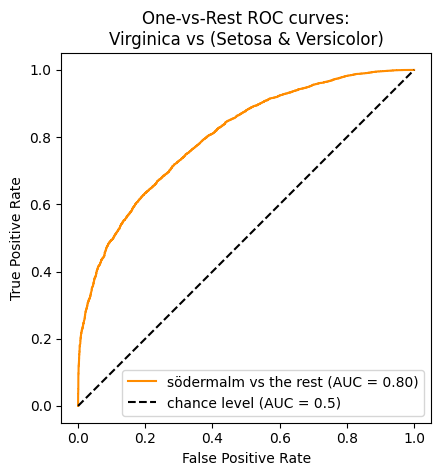

In [232]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

In [233]:
from sklearn.metrics import roc_curve, auc

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.88


In [234]:
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(7):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= 7

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.79


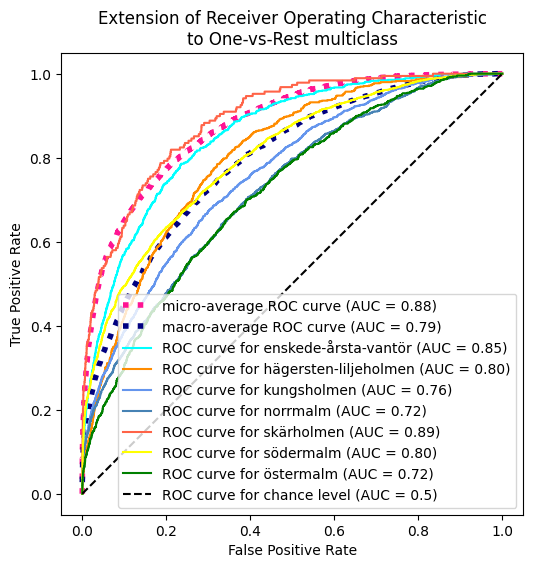

In [235]:
fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = ["aqua", "darkorange", "cornflowerblue", 'steelblue', 'tomato', 'yellow', 'green']
for class_id, color in zip(range(7), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {labels[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()